In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, timedelta

# Load Data

In [2]:
confirmed = pd.read_csv('data/time_series_19-covid-Confirmed.csv')
deaths = pd.read_csv('data/time_series_19-covid-Deaths.csv')
recover = pd.read_csv('data/time_series_19-covid-Recovered.csv')

In [3]:
day = datetime.today() - timedelta(days=2)

In [4]:
datastr = day.strftime('%m/%d')[1:] + '/20'

# Data transformation

In [5]:
confirmed_by_country = confirmed[['Country/Region', datastr]].groupby('Country/Region').sum().rename(columns={datastr: 'n_confirmed'})

In [6]:
deaths_by_country = deaths[['Country/Region', datastr]].groupby('Country/Region').sum().rename(columns={datastr: 'n_deaths'})

In [7]:
recover_by_country = recover[['Country/Region', datastr]].groupby('Country/Region').sum().rename(columns={datastr: 'n_recover'})

In [8]:
global_df = confirmed_by_country.merge(deaths_by_country, how='left', left_index=True, right_index=True).\
merge(recover_by_country, how='left', left_index=True, right_index=True)

In [9]:
confirmed_country_day = confirmed.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum()

In [10]:
recover_country_day = recover.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum()

In [11]:
deaths_country_day = deaths.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum()

In [12]:
ndays_since_first_confirmed = confirmed_country_day.apply(lambda x: (x > 0).sum(), axis=1)

In [13]:
ndays_since_first10_confirmed = confirmed_country_day.apply(lambda x: (x >= 10).sum(), axis=1)

In [14]:
ndays_since_first_death = deaths_country_day.apply(lambda x: (x > 0).sum(), axis=1)

In [15]:
ndays_since_first_recovery = recover_country_day.apply(lambda x: (x > 0).sum(), axis=1)

In [16]:
global_df = global_df.merge(ndays_since_first_confirmed.rename('days'), right_index=True, left_index=True)

In [17]:
global_df = global_df.merge(ndays_since_first_death.rename('ndays_since_first_death'), right_index=True, left_index=True)

In [18]:
global_df = global_df.merge(ndays_since_first_recovery.rename('ndays_since_first_recover'), right_index=True, left_index=True)

In [19]:
global_df = global_df.merge(ndays_since_first10_confirmed.rename('ndays_since_first10_confirmed'), right_index=True, left_index=True)

In [20]:
global_df['unk_state'] = global_df.n_confirmed-global_df.n_deaths-global_df.n_recover

# Analysis

In [21]:
print(f"{global_df.shape[0]} coutries with confirmed cases so far, {global_df.n_confirmed.sum()} confirmed cases, \
{global_df.n_deaths.sum()} deaths and {global_df.n_recover.sum()} recovers.")

132 coutries with confirmed cases so far, 119303 confirmed cases, 4290 deaths and 64411 recovers.


In [22]:
global_df.head()

,n_confirmed,n_deaths,n_recover,days,ndays_since_first_death,ndays_since_first_recover,ndays_since_first10_confirmed,unk_state
Country/Region,,,,,,,,
Afghanistan,5,0,0,17,0,0,0,5
Albania,10,0,0,3,1,0,2,10
Algeria,20,0,0,16,0,0,8,20
Andorra,1,0,0,10,0,0,0,1
Argentina,17,1,0,9,4,0,4,16


In [23]:
global_df.loc[['Italy', 'Mainland China', 'Spain', 'France', 'Netherlands', 'Portugal', 'Germany', 'UK'],\
              ['n_confirmed', 'days', 'ndays_since_first10_confirmed']]

,n_confirmed,days,ndays_since_first10_confirmed
Country/Region,,,
Italy,10149,41,20
Mainland China,80757,49,49
Spain,1695,40,15
France,1784,48,33
Netherlands,382,14,11
Portugal,41,10,6
Germany,1457,45,39
UK,382,40,16


In [24]:
colors = cm.get_cmap('tab20').colors

In [25]:
country_data = confirmed_country_day.loc['Portugal']
country_data = country_data[country_data>=10]

pt_days = len(country_data)

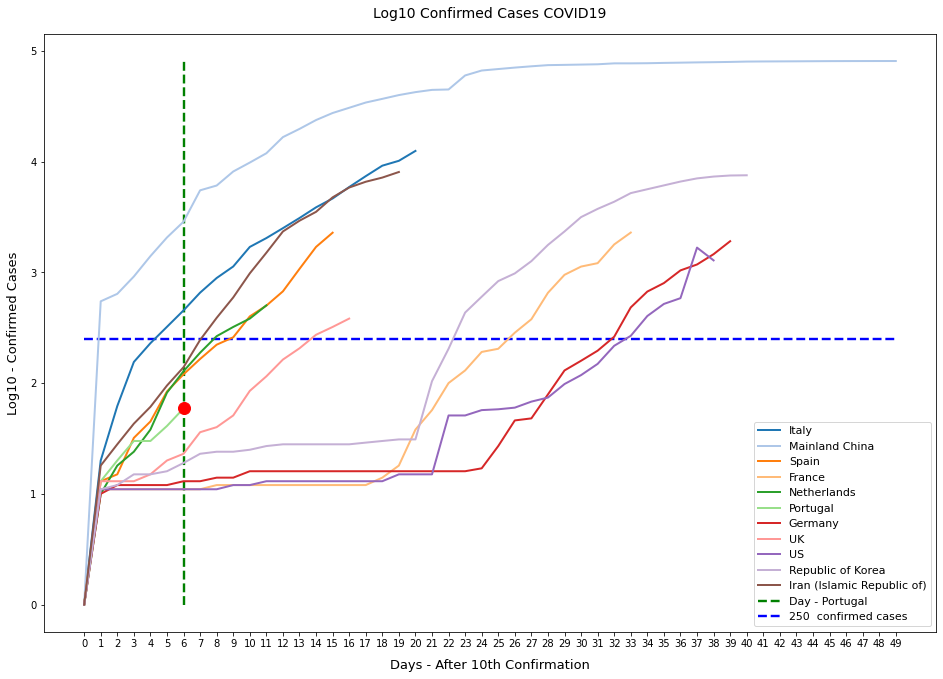

In [26]:
countries = ['Italy', 'Mainland China', 'Spain', 'France', 'Netherlands', 'Portugal', 'Germany', 'UK', 'US'
            , 'Republic of Korea', 'Iran (Islamic Republic of)']
max_total = 0
max_days = 0
plt.figure(figsize=(16,11))


for i, country in enumerate(countries):
    country_data = confirmed_country_day.loc[country]
    country_data = country_data[country_data>=10]
    
    if len(country_data.values) > max_days:
        max_days = len(country_data)
    
    vals = np.log10(country_data.values)
    maxval = vals.max()
    if maxval > max_total:
        max_total = maxval
    
    plt.plot(list(range(len(country_data)+1)), np.concatenate((np.array([0]),vals)), 
             label=country, color=colors[i], linewidth=2)
    
_ = plt.xticks(ticks=list(range(0,max_days+1)))
_ = plt.vlines(x=pt_days, ymin=0, ymax=max_total, linestyles='dashed', colors='g', label='Day - Portugal',
              linewidth=2.4)   

_ = plt.hlines(y=np.log10(250), xmin=0, xmax=max_days, linestyles='dashed', colors='b', label='250  confirmed cases',
              linewidth=2.4)  

_ = plt.legend(loc='lower right', fontsize=11)
_ = plt.title('Log10 Confirmed Cases COVID19', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days - After 10th Confirmation', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Log10 - Confirmed Cases', fontdict={'fontsize':13}, labelpad=10.0)

country_data = confirmed_country_day.loc['Portugal']
country_data = country_data[country_data>=10]
_ = plt.plot(len(country_data), np.log10(country_data[-1]), 'ro', markersize=12)
plt.savefig('data/nconfirmed_log.png')

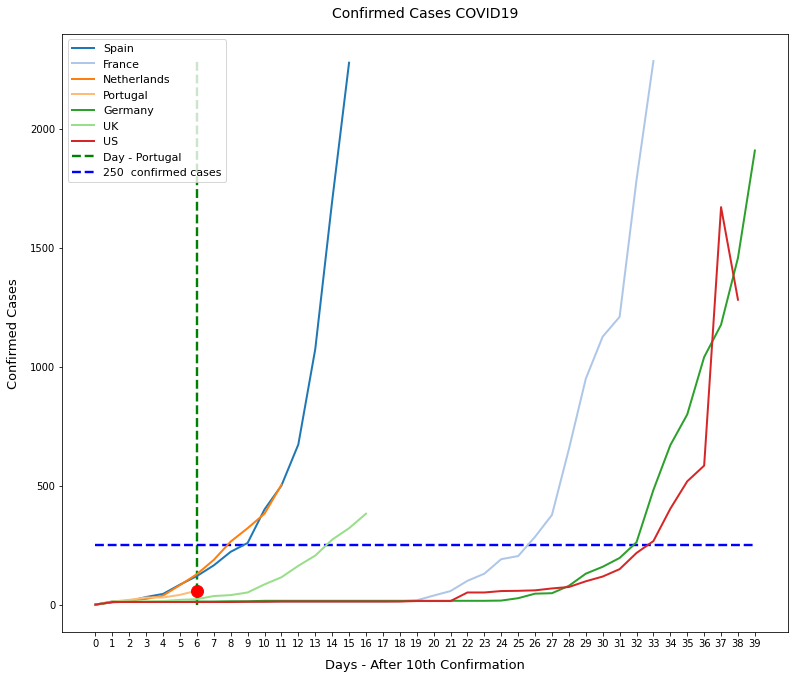

In [27]:
countries = ['Spain', 'France', 'Netherlands', 'Portugal', 'Germany', 'UK', 'US']
max_total = 0
max_days = 0

plt.figure(figsize=(13,11))

for i, country in enumerate(countries):
    country_data = confirmed_country_day.loc[country]
    country_data = country_data[country_data>=10]
    
    if len(country_data.values) > max_days:
        max_days = len(country_data)
    
    vals = country_data.values
    maxval = vals.max()
    if maxval > max_total:
        max_total = maxval
    
    plt.plot(list(range(len(country_data)+1)), np.concatenate((np.array([0]),vals)), 
             label=country, color=colors[i], linewidth=2)

_ = plt.xticks(ticks=list(range(0,max_days+1)))
_ = plt.vlines(x=pt_days, ymin=0, ymax=max_total, linestyles='dashed', colors='g', label='Day - Portugal',
              linewidth=2.4) 
_ = plt.hlines(y=250, xmin=0, xmax=max_days, linestyles='dashed', colors='b', label='250  confirmed cases',
              linewidth=2.4)  
_ = plt.legend(loc='upper left', fontsize=11)
_ = plt.title('Confirmed Cases COVID19', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days - After 10th Confirmation', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Confirmed Cases', fontdict={'fontsize':13}, labelpad=10.0)

country_data = confirmed_country_day.loc['Portugal']
country_data = country_data[country_data>=10]
_ = plt.plot(len(country_data), country_data[-1], 'ro', markersize=12)
plt.savefig('data/nconfirmed_normal.png')

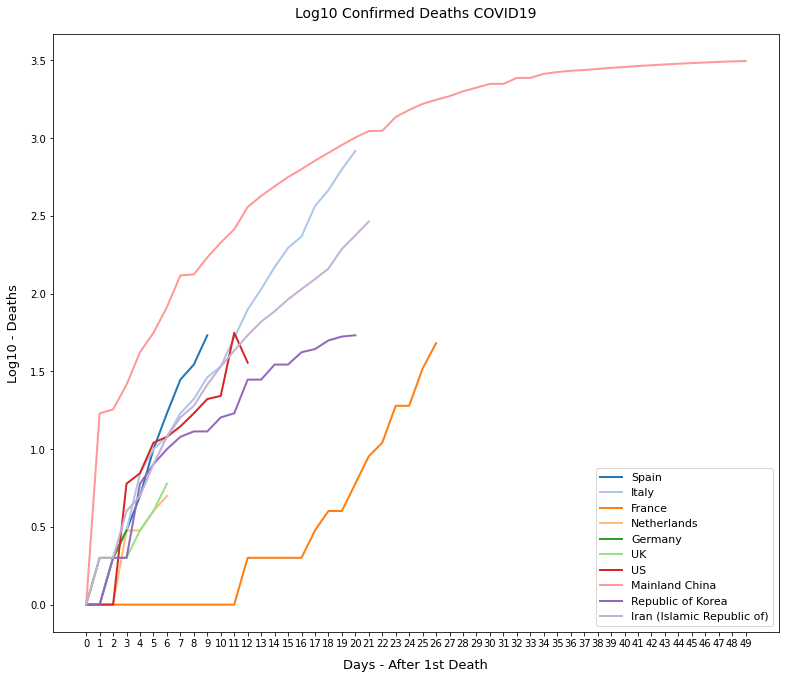

In [28]:
countries = ['Spain', 'Italy', 'France', 'Netherlands', 'Germany', 'UK', 'US', 'Mainland China', 
             'Republic of Korea', 'Iran (Islamic Republic of)']
max_total = 0
max_days = 0

plt.figure(figsize=(13,11))

for i, country in enumerate(countries):
    country_data = deaths_country_day.loc[country]
    country_data = country_data[country_data>=1]
    
    if len(country_data.values) > max_days:
        max_days = len(country_data)
    
    vals = np.log10(country_data.values)
    maxval = vals.max()
    if maxval > max_total:
        max_total = maxval
    
    plt.plot(list(range(len(country_data)+1)), np.concatenate((np.array([0]),vals)), 
             label=country, color=colors[i], linewidth=2)

_ = plt.xticks(ticks=list(range(0,max_days+1)))
_ = plt.legend(loc='lower right', fontsize=11)
_ = plt.title('Log10 Confirmed Deaths COVID19', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days - After 1st Death', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Log10 - Deaths', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/deathslog.png')

In [29]:
global_df.loc[['Mainland China', 'Italy'], 'n_deaths'] / global_df.loc[['Mainland China', 'Italy'], 'n_confirmed']

Country/Region
Mainland China    0.038833
Italy             0.062174
dtype: float64